In [1]:
import numpy as np
import torch
from scipy.io import loadmat
import matplotlib.pylab as plt
# DeepMoD stuff
from deepymod_torch import DeepMoD
from deepymod_torch.model.func_approx import NN
from deepymod_torch.model.library import Library1D
from deepymod_torch.model.constraint import LeastSquares
from deepymod_torch.model.sparse_estimators import  Threshold, PDEFIND
from deepymod_torch.training import train_split_full
from deepymod_torch.training.sparsity_scheduler import TrainTestPeriodic

if torch.cuda.is_available():
    device ='cuda'
else:
    device = 'cpu'

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
V2_2 = np.loadtxt('data/data_17_09/V1_V2/data_V2.csv', delimiter=',', skiprows=3)
V2_3 = np.loadtxt('data/data_17_09/V1_V3/data_V3.csv', delimiter=',', skiprows=3)
V2_4 = np.loadtxt('data/data_17_09/V1_V4/data_V4.csv', delimiter=',', skiprows=3)
V2_5 = np.loadtxt('data/data_17_09/V1_V5/data_V5.csv', delimiter=',', skiprows=3)
V2_6 = np.loadtxt('data/data_17_09/V1_V6/data_V6.csv', delimiter=',', skiprows=3)
V2_7 = np.loadtxt('data/data_17_09/V1_V7/data_V7.csv', delimiter=',', skiprows=3)
V2_8 = np.loadtxt('data/data_17_09/V1_V8/data_V8.csv', delimiter=',', skiprows=3)
V2_9 = np.loadtxt('data/data_17_09/V1_V9/data_V9.csv', delimiter=',', skiprows=3)
V2_10 = np.loadtxt('data/data_17_09/V1_V10/data_V10.csv', delimiter=',', skiprows=3)
V2_11 = np.loadtxt('data/data_17_09/V1_V11/data_V11.csv', delimiter=',', skiprows=3)
V2_12 = np.loadtxt('data/data_17_09/V1_V12/data_V12.csv', delimiter=',', skiprows=3)
V2_13 = np.loadtxt('data/data_17_09/V1_V13/data_V13.csv', delimiter=',', skiprows=3)
V2_14 = np.loadtxt('data/data_17_09/V1_V14/data_V14.csv', delimiter=',', skiprows=3)
V2_15 = np.loadtxt('data/data_17_09/V1_V15/data_V15.csv', delimiter=',', skiprows=3)

In [3]:
delta_V = np.concatenate((V2_2[:, 1:], V2_3[:, 1:], V2_4[:, 1:], V2_5[:, 1:], V2_6[:, 1:], V2_7[:, 1:], V2_8[:, 1:], V2_9[:, 1:], V2_10[:, 1:], V2_11[:, 1:], V2_12[:, 1:], V2_13[:, 1:], V2_14[:, 1:], V2_15[:, 1:]), axis=1)
#delta_V_1 = np.concatenate((V10_2[:, 1:], V10_3[:, 1:], V10_4[:, 1:], V10_5[:, 1:], V10_6[:, 1:], V10_7[:, 1:], V10_8[:, 1:], V10_9[:, 1:], V10_10[:, 1:]), axis=1)

In [4]:
delta_V.shape

(4064, 14)

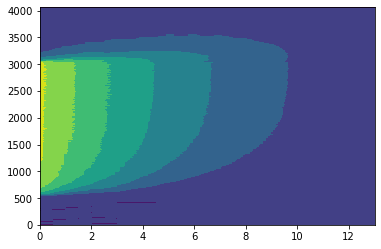

In [5]:
#plt.figure(figsize=(6, 6))
#plt.subplot(121)
plt.contourf(delta_V[:,:])

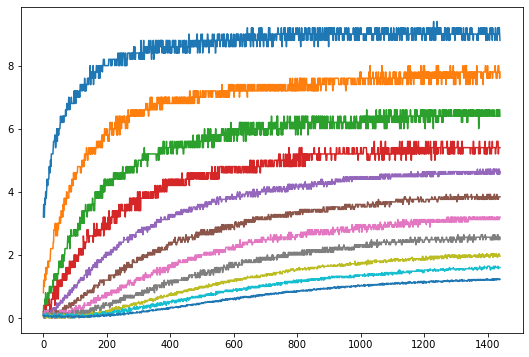

In [6]:
plt.figure(figsize=(9, 6))
plt.plot(V2_2[560:2000, 1])
plt.plot(V2_3[560:2000, 1])
plt.plot(V2_4[560:2000, 1])
plt.plot(V2_5[560:2000, 1])
plt.plot(V2_6[560:2000, 1])
plt.plot(V2_7[560:2000, 1])
plt.plot(V2_8[560:2000, 1])
plt.plot(V2_9[560:2000, 1])
plt.plot(V2_10[560:2000, 1])
plt.plot(V2_11[560:2000, 1])
plt.plot(V2_12[560:2000, 1])
#plt.plot(time, V2_4[:, 1])

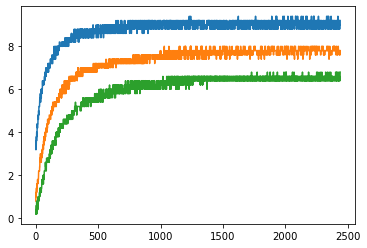

In [7]:
plt.plot(V2_2[560:3000, 1])
plt.plot(V2_3[560:3000, 1])
plt.plot(V2_4[560:3000, 1])

In [8]:
output_data = delta_V[560:2000,:].T
output_data.shape

(14, 1440)

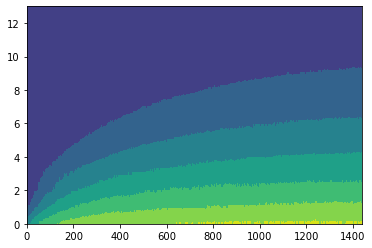

In [9]:
plt.contourf(output_data)

In [10]:
x = np.linspace(0, 1, output_data.shape[0])
t = np.linspace(0, 1, output_data.shape[1])
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')
X = np.transpose((t_grid.flatten(), x_grid.flatten()))
y = np.real(output_data).reshape((output_data.size, 1))
y = y/np.max(y)

In [11]:
number_of_samples = 2500

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)

In [12]:
network = NN(2, [30, 30, 30, 30, 30, 30, 30], 1)
library = Library1D(poly_order=1, diff_order=2) # Library function
estimator = PDEFIND(lam=1e-4) # Sparse estimator 
constraint = LeastSquares() # How to constrain
model = DeepMoD(network, library, estimator, constraint).to(device) # Putting it all in the model

In [13]:
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=8, delta=1e-5) # in terms of write iterations
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) # Defining optimizer

In [14]:
train_split_full(model, X_train, y_train, optimizer,sparsity_scheduler, log_dir='runs/exp_data_3/', split=0.8, test='full', write_iterations=25, max_iterations=100000, delta=1e-5, patience=20) 

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
     100000    100.00%               0s   1.10e-04   1.09e-04   1.20e-06   2.53e+00 

In [15]:
train_split_full(model, X_train, y_train, optimizer,sparsity_scheduler, log_dir='runs/exp_data_4/', split=0.8, test='full', write_iterations=25, max_iterations=100000, delta=1e-5, patience=20) 

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
     100000    100.00%               0s   1.04e-04   1.03e-04   6.80e-07   2.34e+00 

In [16]:
train_split_full(model, X_train, y_train, optimizer,sparsity_scheduler, log_dir='runs/exp_data_5/', split=0.8, test='full', write_iterations=25, max_iterations=100000, delta=1e-5, patience=20) 

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
     100000    100.00%               0s   1.03e-04   1.02e-04   4.28e-07   2.27e+00 